## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

-------------------------------

Предположим, что у нас уже получен объединенный датафрейм:

In [20]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm
from scipy.stats import norm 
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt

import re

Не будем дублировать функцию бутстрапа внутри нашей функции, объявим ее заранее:

In [2]:
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 1000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор програсса
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираем отрисовывать индикатора програсса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отрисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

Допустим, что у нас имеется датафрейм:

In [3]:
links_dic = {
    'groups':       ['groups.csv', ';'],
    'active_studs': ['active_studs.csv', ','],
    'checks':       ['checks.csv', ';']
            }

for csv_filename, csv_link in links_dic.items():
    globals()[csv_filename] = pd.read_csv(csv_link[0], sep=csv_link[1])

In [4]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'}).assign(payment = 1)

In [240]:
df = pd.merge(pd.merge(active_studs, checks, on='id', how='left'), groups, on='id').assign(step=0)

In [241]:
df = df.fillna(0)

In [242]:
df.head()

,id,rev,payment,grp,step
0,581585,0.0,0.0,A,0
1,3276743,0.0,0.0,B,0
2,4238589,0.0,0.0,A,0
3,4475369,0.0,0.0,B,0
4,5481015,0.0,0.0,B,0


У нас имеется ссылка на дополнительный файл (на Яндекс.Диске, или локально):

In [250]:
# ссылка на дополнительный файл
#add_csv_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
# или 
add_csv_link = 'group_add.csv'
#update_metrics(df, add_csv_link)

In [249]:
# скачиваем дополнительный файл
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url    = base_url + urlencode(dict(public_key=add_csv_link))
response     = requests.get(final_url)
download_url = response.json()['href']
group_add_df = pd.read_csv(download_url, sep=',')

# загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('group_add.csv', 'wb') as f:
    f.write(download_response.content)

# открываем файл
group_add_df = pd.read_csv('group_add.csv', sep=',')

KeyError: 'href'

**Напишем функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` и пересчитывать метрики:**

In [244]:
def update_metrics(df, add_csv_link, last_string=False):
    '''
    Функция пересчёта метрик.
    На выходе - датафрэйм со значениями метрик и p-value, 
    Кол-во строк соответствует кол-ву повторных обновлений данных(step)
    df       - объединённый дф из groups.csv, active_studs.csv, checks.csv (получены в первый раз).
    add_csv_link  - ссылка на дополнительный файл groups_add.csv, 
                    возможно использование web-ссылки на Яндекс.Диск, или ссылки на файл в каталоге.
    last_string         - если True, выведет только последнюю (финальную) строку таблицы.
    '''
    #3 подфункции:
    # ф-я определения разделителя в csv-файле
    def def_sep(file_link):
        with open(file_link, 'r') as file:
            temp = file.readline()
        pattern = re.compile(r'\w*([,;])\w*')
        return pattern.findall(temp)[0]


    # переименовываем колонки по типу данных
    def rename_cols(df):
        if str(df.iloc[0, 0]).isalpha():
            df.columns = ['grp', 'id']
        else:
            df.columns = ['id', 'grp']

    # чистим и заполняем пропуски 
    def na_filter(df, to_dropna_ls=['grp'], to_fillna_ls=['payment', 'rev']):
        df = (df
             .copy()
             .dropna(subset=to_dropna_ls)
             )
        for i in to_fillna_ls:
            df[i] = df[i].fillna(0)
        return df
    
    # ф-я среднего, необходимая для ф-ии бутстрапа
    def mean_f(y):
        return np.mean(y)

    try:
        if add_csv_link.startswith('https://'):

            # скачиваем дополнительный файл
            base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
            final_url    = base_url + urlencode(dict(public_key=add_csv_link))
            response     = requests.get(final_url)
            download_url = response.json()['href']
            group_add_df = pd.read_csv(download_url, sep=',')

            # загружаем файл и сохраняем его
            download_response = requests.get(download_url)
            with open('group_add.csv', 'wb') as f:
                f.write(download_response.content)

            # открываем файл
            group_add_df = pd.read_csv('group_add.csv', sep=def_sep('group_add.csv'))
        else:

            # открываем файл
            group_add_df = pd.read_csv(add_csv_link, sep=def_sep(add_csv_link))
    except:
        print('ОШИБКА! Дополнительные пользователи не загружены')
        
    # переименуем колонки в соответствие с типом данных
    rename_cols(group_add_df)
    
    # объединяем основной дф с дополнительным
    df          = df.merge(group_add_df, on='id', how='outer')
    df['grp_x'] = df.grp_x.fillna('')                  # заполняем пропуски пустым символом
    df['grp_y'] = df.grp_y.fillna('')                  # заполняем пропуски пустым символом
    df['grp']   = df.grp_x + df.grp_y             # объединяем колонки групп
    df          = df.drop(['grp_x', 'grp_y'], axis=1)  # удаляем колонки grp_x и grp_y

    # присваиваем значения step в добавленных строках
    mask = df.id.isin(group_add_df.id)             # назначаем маску, согласно которой будем присваивать новый номер степа
    df.loc[mask, 'step'] = df.step.max() + 1  # присваиваем номер степа
    df['step'] = df.step.astype('int')        # переводим колонку степ в int
    
    # отфильтруем пропуски
    df = na_filter(df)
    
    # пересчитываем метрики, каждый цикл - новое добавление файла groups_add
    df_ab = pd.DataFrame()  # пустой датафрейм для заполнения 

    for i in range(df.step.max() + 1):  # итеритуемся по максимальному значению колонки step +1
        # фильтруем датасет для рассчёта метрик
        rev_a      = df.query('step <= @i and grp =="A"').rev
        rev_b      = df.query('step <= @i and grp =="B"').rev
        rev_positive_a = df.query('step <= @i and rev > 0 and grp =="A"').rev
        rev_positive_b = df.query('step <= @i and rev > 0 and grp =="B"').rev
    
        all_A   = df[df.payment==0].query('step <= @i and grp=="A"').count()[0]
        payed_A = df[df.payment==1].query('step <= @i and grp=="A"').count()[0]
        all_B   = df[df.payment==0].query('step <= @i and grp=="B"').count()[0]
        payed_B = df[df.payment==1].query('step <= @i and grp=="B"').count()[0]

        #конверсия по группам 
        cr_a = payed_A/all_A
        cr_b = payed_B/all_B
        #Хи - квадрат тест конверсии
        group_A = [all_A, payed_A]
        group_B = [all_B, payed_B]
  
        chi2, cr_p_value, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)
        
        #ARPU по группам
        arpu_a = mean_f(rev_a)
        arpu_b = mean_f(rev_b)
        #ARPU p-value
        arpu_p_value = get_bootstrap(rev_a, 
                                     rev_b,
                                     statistic=mean_f,
                                     graph = False,
                                     show_progress = False
                       )["p_value"]
        #ARPPU по группам
        arppu_a       = mean_f(rev_positive_a)
        arppu_b       = mean_f(rev_positive_b)
        #ARPPU p-value
        arppu_p_value = get_bootstrap(rev_positive_a,
                                      rev_positive_b,
                                      statistic=mean_f,
                                      graph = False,
                                      show_progress = False
                        )["p_value"]

        # временный датафрэйм
        temp_df = pd.DataFrame([[cr_a, 
                                 cr_b, 
                                 cr_p_value, 
                                 arpu_a, 
                                 arpu_b, 
                                 arpu_p_value, 
                                 arppu_a, 
                                 arppu_b, 
                                 arppu_p_value]],
                               columns=['CR_A',
                                        'CR_B',
                                        'CR_p-value',
                                        'ARPU_A',
                                        'ARPU_B',
                                        'ARPU_p-value', 
                                        'ARPPU_A',
                                        'ARPPU_B',
                                        'ARPPU_p-value'])
        # добавляем строку в итоговый дф
        df_ab = pd.concat([df_ab, temp_df])      
    
    # сбрасываем индексы
    df_ab.reset_index(drop=True, inplace=True)  
    df_ab['step'] = df_ab.index
    
    if last_string == True:
        return df_ab.tail(1)
    
    return df_ab

В функцию `get_update` передадим предварительно сформированный датафрейм `total_test`:

In [255]:
metrics = update_metrics(df, add_csv_link)
metrics

,CR_A,CR_B,CR_p-value,ARPU_A,ARPU_B,ARPU_p-value,ARPPU_A,ARPPU_B,ARPPU_p-value,step
0,0.053535,0.048302,0.428082,47.439739,57.864567,0.041794,933.589744,1255.827487,0.000003,0
1,0.052738,0.047786,0.447235,46.769428,57.274370,0.041113,933.589744,1255.827487,0.000003,1


Напишем функцию отрисовки графиков:

In [273]:
def get_graphs(df):
    '''
    Функция построения графика на основе датасэта, сформированного функцией get_update
    Шесть графиков: 
    по оси X - номер обновления (колонка step в передаваемом дф), показывает 
    какой раз обновились данные (некий аналог временной шкалы, т.к. не известны даты создания 
    дополнительных файлов)
    по оси Y - метрики (верхний ряд графиков) и p-value этих метрик (нижний ряд графиков)
    '''
    # формируем датафрэйм для отрисовки метрик
    import pandas as pd
    metrix_df = pd.DataFrame(columns = ['step', 'group'])                     # создаём пустой финальный дф для построения графиков метрик
    for i in ['CR_', 'ARPU_', 'ARPPU_']:                                      # список части названий колонок для отбора
        cols    = df.filter(like = i).columns                                 # отбираем колонки содержащие названия метрик
        temp_df = pd.DataFrame()                                              # создаём пустой дф
        for j in cols[:2]:                                                    # итерируемся по названиям колонок, кроме p-value
            tmp_row         = df[[j, 'step']] \
            .assign(group = j[-1:]) \
            .rename(columns = {j: j[:-2]})  # формируем строку нового дф
            temp_df         = pd.concat([temp_df, tmp_row])                   # добавляем строку в промежуточный дф
        metrix_df = metrix_df \
                    .merge(temp_df, on=['step', 'group'], how='right')        # объединяем промежуточный дф с финальным

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd

    df1 = metrix_df.query('step==0').drop(columns=['step']).set_index("group")
    df2 = metrix_df.query('step==1').drop(columns=['step']).set_index("group")

    fig = make_subplots(
        rows=len(df1),
        cols=len(df1.columns),
        specs=[[{"type": "indicator"} for c in range(3)] for t in range(2)]
    )

    for r, grp in enumerate(df1.index):
        for c, metr in enumerate(df1.columns):
            fig.add_trace(
                go.Indicator(mode="number+delta", value=df1.loc[grp, metr], title={"text":f"{metr} - {grp}"},
                             delta = {'reference': df2.loc[grp, metr], 
                         'relative': True}),
                row=r + 1,
                col=c + 1,
            )

    fig.update_layout(margin={"l": 0, "r": 20, "t": 50, "b": 0})       
    # формируем блок из 6 графиков

    figure, axes = plt.subplots(2, 3, sharex=True, figsize=(16,7))   
       
    # заголовок
    figure.suptitle('Метрики и p-value', fontsize=20)   
    
    # графики CR и p-value для CR
    sns.lineplot(ax=axes[0, 0], data=metrix_df, x='step', y='CR', hue='group', linewidth=2, palette=['b', 'g'])
    ax1 = sns.lineplot(ax=axes[1, 0], data=df, x='step', y='CR_p-value', linewidth=2, color="green", label='p-value')
    ax1.axhline(0.05, ls='--', linewidth=1.5, color='red', label='p-value = 0.05')
    ax1.set_ylabel('P-value для CR')
    ax1.set_xlabel('Номер обновления')
    ax1.legend()
    
    # графики ARPU и p-value для ARPU
    sns.lineplot(ax=axes[0, 1], data=metrix_df, x='step', y='ARPU', hue='group', linewidth=2, palette=['b', 'g'])
    ax2 = sns.lineplot(ax=axes[1, 1], data=df, x='step', y='ARPU_p-value', linewidth=2, color="green", label='p-value')
    ax2.axhline(0.05, ls='--', linewidth=1.5, color='red', label='p-value = 0.05')
    ax2.set_ylabel('P-value для ARPU')
    ax2.set_xlabel('Номер обновления')
    ax2.legend()
    
    # графики ARPPU и p-value для ARPPU
    sns.lineplot(ax=axes[0, 2], data=metrix_df, x='step', y='ARPPU', hue='group', linewidth=2, palette=['b', 'g'])
    ax3 = sns.lineplot(ax=axes[1, 2], data=df, x='step', y='ARPPU_p-value', linewidth=2, color="green", label='p-value')
    ax3.axhline(0.05, ls='--', linewidth=1.5, color='red', label='p-value = 0.05')
    ax3.set_ylabel('P-value для ARPPU ')
    ax3.set_xlabel('Номер обновления')
    ax3.set_xticks(range(0, metrix_df.step.max() + 1))  # сделаем шаг по оси х = 1
    ax3.legend()
    
    # устанавливаем лимиты на ось y
    plt.gcf().get_axes()[0].set_ylim(metrix_df.CR.min() * 0.9, metrix_df.CR.max() * 1.1)                  
    plt.gcf().get_axes()[1].set_ylim(metrix_df.ARPU.min() * 0.9, metrix_df.ARPU.max() * 1.1)
    plt.gcf().get_axes()[2].set_ylim(metrix_df.ARPPU.min() * 0.9, metrix_df.ARPPU.max() * 1.1)
    plt.gcf().get_axes()[3].set_ylim(min(0.05, metrix['CR_p-value'].min()) * 0.9, 
                                     max(0.05, metrix['CR_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[4].set_ylim(min(0.05, metrix['ARPU_p-value'].min()) * 0.9, 
                                     max(0.05, metrix['ARPU_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[5].set_ylim(min(0.05, metrix['ARPPU_p-value'].min()) * 0.9, 
                                     max(0.05, metrix['ARPPU_p-value'].max()) * 1.1)
    
    # добавляем расстояния между графиками
    plt.subplots_adjust(top=0.92, hspace = 0.1, wspace=0.3)
    
    from plotly.offline import iplot
    return iplot(fig)

В функцию `get_graphs` передадим метрики, записанные в переменную `metrix`:

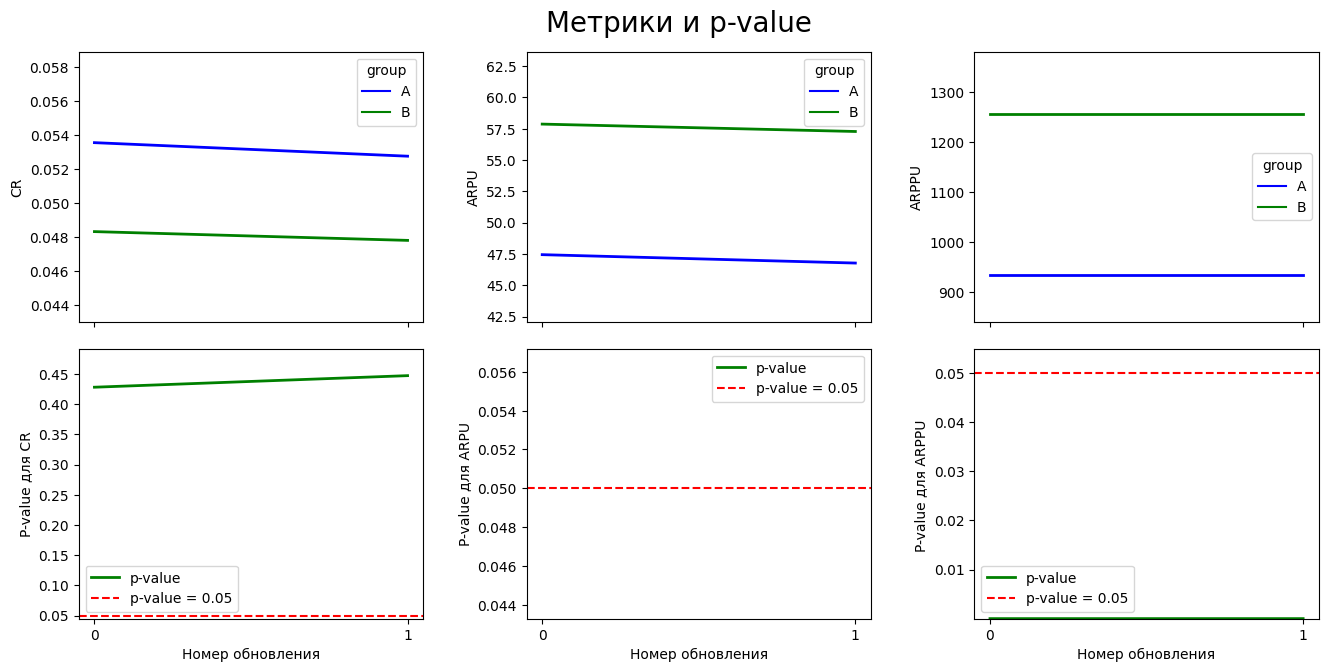

In [278]:
get_graphs(metrics)